# Brain Tumor Visual Transformer (ViT) Training Notebook

Dependency Installation

In [ ]:
!pip install evaluate

Imports

In [2]:
import torch, os, torch.nn, torch.optim
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from transformers import ViTForImageClassification
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader, Dataset
from google.colab import drive

Environment

In [3]:
DATASET="/content/drive/MyDrive/BrainImageClassification/data/kaggle"
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/drive')

Mounted at /content/drive


Initializing Datasets and DataLoaders

In [4]:
train_dataset=datasets.ImageFolder(root=os.path.join(DATASET,'Training'), transform=transforms.Compose([transforms.Resize((224,224)),
                                                                                                        transforms.RandomHorizontalFlip(p=0.5),
                                                                                                        transforms.RandomRotation(degrees=15),
                                                                                                        transforms.ToTensor(),
                                                                                                        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])]))

validation_dataset=datasets.ImageFolder(root=os.path.join(DATASET,'Testing'), transform=transforms.Compose([transforms.Resize((224,224)),
                                                                                                          transforms.ToTensor(),
                                                                                                          transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])]))

In [12]:
train_data_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2)
validation_data_loader=DataLoader(validation_dataset,batch_size=32,shuffle=False,num_workers=2)

Initializing the ViT Model and training resources

In [13]:
vit_model=ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',num_labels=4,ignore_mismatched_sizes=True)
vit_model.to(device)

ce_loss=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(vit_model.parameters(),lr=1e-4)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
train_losses,train_accuracies=[],[]
validation_losses,validation_accuracies=[],[]
best_validation_accuracy=0

In [15]:
NUM_EPOCHS=5

Training the model

In [17]:
for epoch in range(NUM_EPOCHS):
  print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
  vit_model.train()
  current_loss=0.0
  correct_classifications,total_classifications=0,0
  for images,labels in tqdm(train_data_loader,desc="Training"):
    images,labels=images.to(device),labels.to(device)

    optimizer.zero_grad()
    outputs=vit_model(images).logits
    loss=ce_loss(outputs,labels)
    loss.backward()
    optimizer.step()

    current_loss=current_loss+loss.item()
    total_classifications=total_classifications+labels.size(0)
    correct_classifications=correct_classifications+outputs.max(1)[1].eq(labels).sum().item()

  train_losses.append(current_loss/len(train_data_loader))
  train_accuracies.append(correct_classifications/total_classifications)
  print(f'Training Loss: {train_losses[-1]}')
  print(f'Training Accuracy: {train_accuracies[-1]}')

  vit_model.eval()
  current_loss=0.0
  correct_classifications,total_classifications=0,0
  predictions=[]
  labels=[]

  with torch.no_grad():
    for i,l in tqdm(validation_data_loader,desc="Validation"):
      i,l=i.to(device),l.to(device)
      outputs=vit_model(i).logits
      loss=ce_loss(outputs,l)
      current_loss=current_loss+loss.item()
      total_classifications=total_classifications+l.size(0)
      correct_classifications=correct_classifications+outputs.max(1)[1].eq(l).sum().item()
      predictions.extend(outputs.max(1)[1].cpu().numpy())
      labels.extend(l.cpu().numpy())

  validation_losses.append(current_loss/len(validation_data_loader))
  validation_accuracies.append(correct_classifications/total_classifications)

  print(f'Validation Loss: {validation_losses[-1]}')
  print(f'Validation Accuracy: {validation_accuracies[-1]}')

  if best_validation_accuracy<validation_accuracies[-1]:
    best_validation_accuracy=validation_accuracies[-1]
    torch.save(vit_model.state_dict(),'vit_model.pth')

Epoch 1/5


Training: 100%|██████████| 179/179 [00:40<00:00,  4.37it/s]


Training Loss: 0.07254834887545618
Training Accuracy: 0.976890756302521


Validation: 100%|██████████| 41/41 [08:06<00:00, 11.87s/it]


Validation Loss: 0.026415290806453856
Validation Accuracy: 0.9916094584286804
Epoch 2/5


Training: 100%|██████████| 179/179 [00:41<00:00,  4.36it/s]


Training Loss: 0.03224681860373184
Training Accuracy: 0.9910714285714286


Validation: 100%|██████████| 41/41 [00:04<00:00,  9.72it/s]


Validation Loss: 0.0348269483333641
Validation Accuracy: 0.988558352402746
Epoch 3/5


Training: 100%|██████████| 179/179 [00:40<00:00,  4.39it/s]


Training Loss: 0.025524089918029624
Training Accuracy: 0.9921218487394958


Validation: 100%|██████████| 41/41 [00:04<00:00,  9.24it/s]


Validation Loss: 0.033759096627785236
Validation Accuracy: 0.9893211289092296
Epoch 4/5


Training: 100%|██████████| 179/179 [00:40<00:00,  4.38it/s]


Training Loss: 0.042197864788666356
Training Accuracy: 0.9872198879551821


Validation: 100%|██████████| 41/41 [00:04<00:00,  9.66it/s]


Validation Loss: 0.04194840943907876
Validation Accuracy: 0.988558352402746
Epoch 5/5


Training: 100%|██████████| 179/179 [00:40<00:00,  4.38it/s]


Training Loss: 0.042720366948331034
Training Accuracy: 0.9866946778711485


Validation: 100%|██████████| 41/41 [00:04<00:00,  9.64it/s]


Validation Loss: 0.02252443786568531
Validation Accuracy: 0.9938977879481312


Classification Report

In [18]:
print("\nClassification Report:")
print(classification_report(labels,predictions,target_names=train_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



Training and Validation Loss

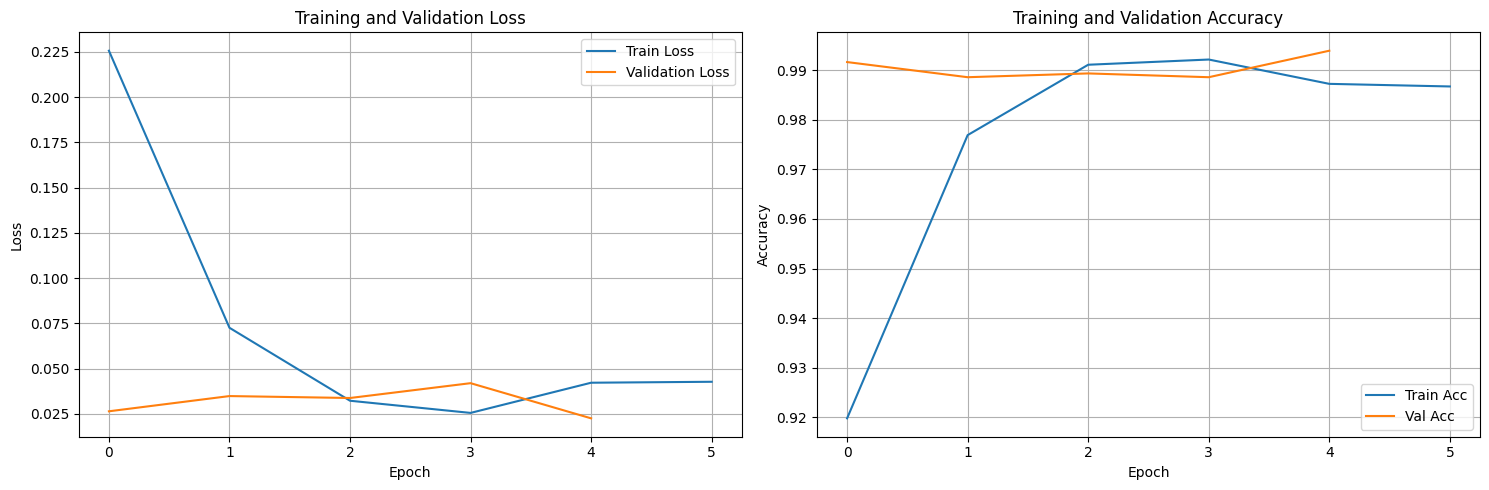

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses,label='Train Loss')
ax1.plot(validation_losses,label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax2.plot(train_accuracies,label='Train Acc')
ax2.plot(validation_accuracies,label='Val Acc')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

Confusion Matrix

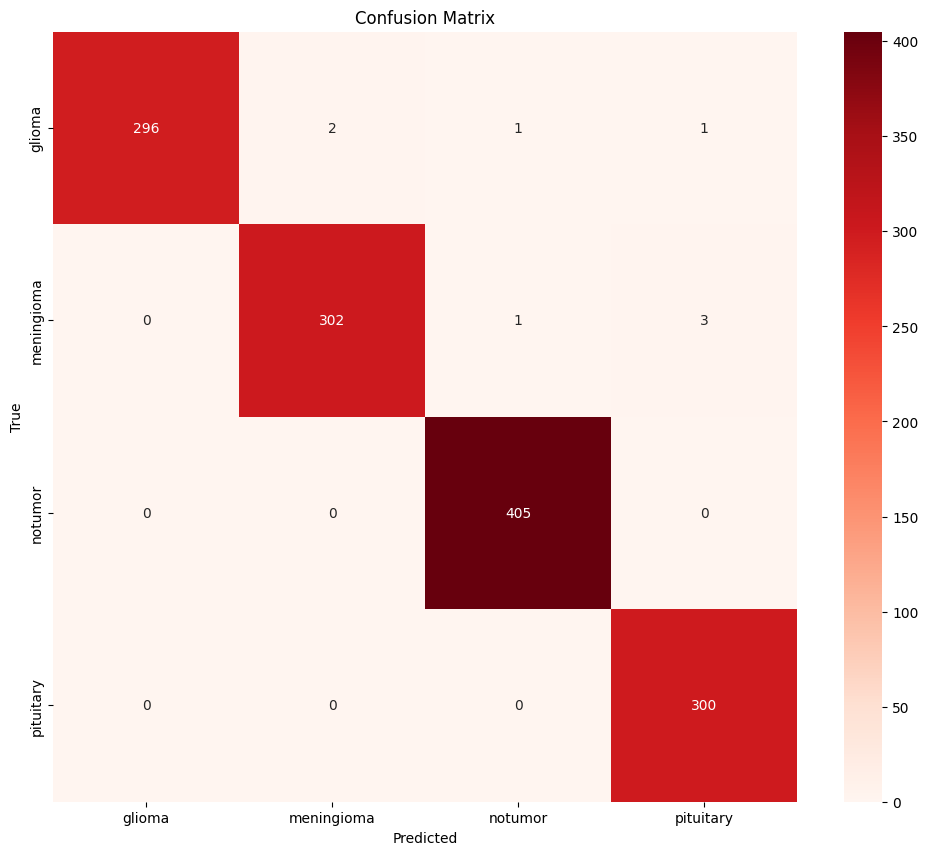

In [22]:
cm = confusion_matrix(labels,predictions)
plt.figure(figsize=(12,10))
sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',xticklabels=train_dataset.classes,yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()